In [6]:
import torch

device = 'cpu'

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

In [11]:
model_path

'patchtst_Air_Temperature_(OC).pt'

In [15]:
test_df = pd.read_csv("Amman_test_data/amman_test.csv")
test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df = test_df.set_index(test_df['time']).drop(columns=['Unnamed: 0', 'time'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3645 entries, 2023-12-31 01:00:00 to 2024-05-30 21:00:00
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Dew Point         3645 non-null   float64
 1   Air Temperature (OC)  3645 non-null   float64
 2   Humidity %            3645 non-null   float64
 3   Atmospheric Pressure  3645 non-null   float64
 4   Liquid Precipitation  3645 non-null   float64
 5   Cloud Cover %         3645 non-null   float64
 6   Wind_U                3645 non-null   float64
 7   Wind_V                3645 non-null   float64
dtypes: float64(8)
memory usage: 256.3 KB


In [16]:
test_df.tail()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind_U,Wind_V
time,,,,,,,,
2024-05-30 17:00:00,9.733333,21.0,52.802638,1013.019989,0.0,0.0,5.552,-1.723333
2024-05-30 18:00:00,9.733333,19.4,53.092129,1013.019989,0.0,25.0,5.552,-1.723333
2024-05-30 19:00:00,9.733333,17.0,67.769404,1013.019989,0.0,0.0,5.552,-1.723333
2024-05-30 20:00:00,9.733333,17.0,72.401375,1013.019989,0.0,0.0,5.552,-1.723333
2024-05-30 21:00:00,9.733333,15.4,75.545003,1013.019989,0.0,25.0,5.552,-1.723333


Processing: Air Dew Point


C:\Users\20210291\AppData\Local\Temp\ipykernel_26508\3782153172.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

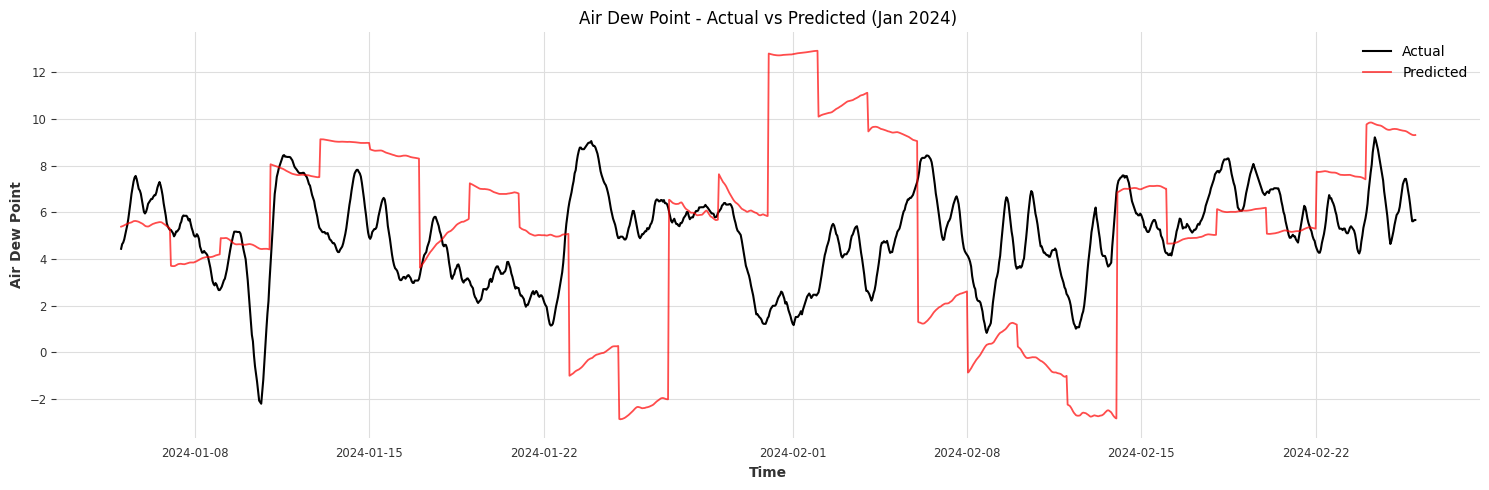

Processing: Air Temperature (OC)


C:\Users\20210291\AppData\Local\Temp\ipykernel_26508\3782153172.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

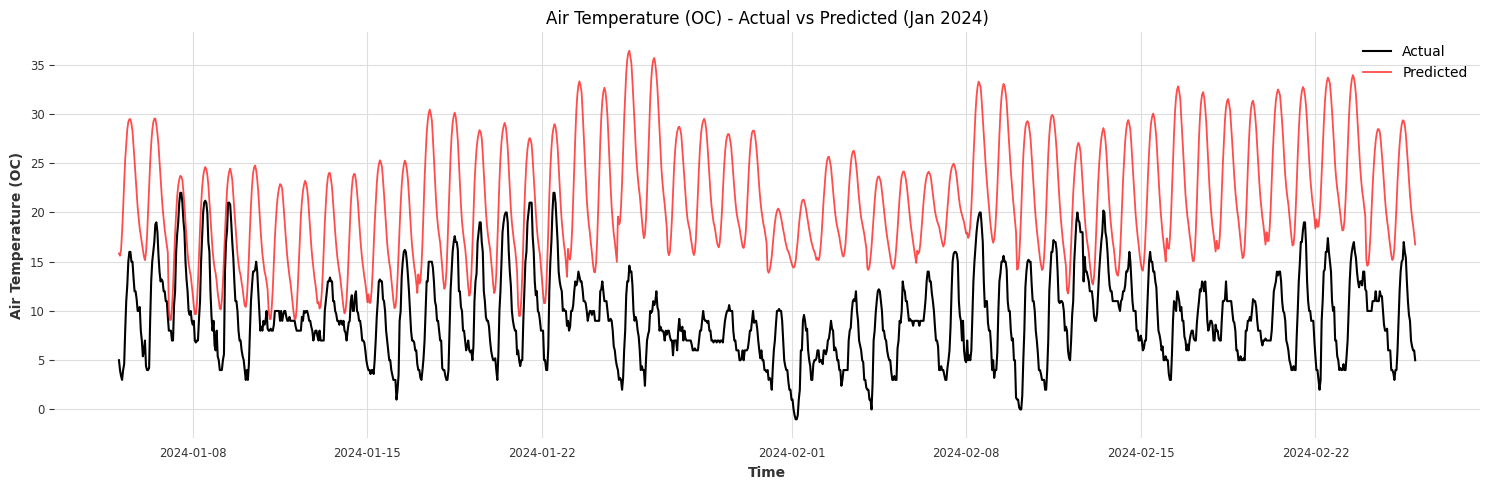

Processing: Humidity %


C:\Users\20210291\AppData\Local\Temp\ipykernel_26508\3782153172.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

RuntimeError: Error(s) in loading state_dict for PatchTSTForPrediction:
	size mismatch for model.encoder.positional_encoder.position_enc: copying a param with shape torch.Size([168, 128]) from checkpoint, the shape in current model is torch.Size([120, 128]).
	size mismatch for head.projection.weight: copying a param with shape torch.Size([120, 128]) from checkpoint, the shape in current model is torch.Size([48, 128]).
	size mismatch for head.projection.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([48]).

In [27]:
input_len = 120
output_len = 48
model_dir = r"Models\Other_Vars"
scaler_path = os.path.join(model_dir, "amman_scaler.pkl")

features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
all_features = features + cyclical

scaler: StandardScaler = joblib.load(scaler_path)

test_df = pd.read_csv("Amman_test_data/amman_test.csv")
test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df = test_df.set_index(test_df['time']).drop(columns=['Unnamed: 0', 'time'])



#Cyclical features
test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['hour'] = test_df.index.hour
test_df['day_cos'] = np.cos(2 * np.pi * test_df['day'] / 31)
test_df['day_sin'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df.drop(['day', 'month', 'hour'], axis=1, inplace=True)
#Scale
test_scaled = scaler.transform(test_df[all_features])
test_scaled = pd.DataFrame(test_scaled, columns=all_features, index=test_df.index)
test_scaled = test_scaled[(test_scaled.index > pd.to_datetime('2024-04-01'))
    & (test_scaled.index < pd.to_datetime('2024-05-30'))]
#loop for plot
for target_feature in features:
    print(f"Processing: {target_feature}")
    
    #Load model
    config = PatchTSTConfig(
        context_length=input_len,
        prediction_length=output_len,
        patch_len=24,
        stride=8,
        d_model=128,
        n_heads=8,
        num_encoder_layers=3,
        dropout=0.1,
        head_dropout=0.1,
        num_input_channels=len(all_features),
        num_targets=1,
        scaling="std",
    )
    model = PatchTSTForPrediction(config).to(device)
    model_path = f"patchtst_{target_feature.replace(' ', '_')}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    inputs = test_scaled[all_features].values
    target_actual = test_df[target_feature].values

    predictions = []
    actuals = []
    timestamps = []

    for i in range(input_len, len(inputs) - output_len + 1, output_len):
        x = inputs[i - input_len:i]
        y_true = target_actual[i:i + output_len]

        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            y_pred = model(x_tensor).prediction_outputs.squeeze(0).cpu().numpy()  # [24, 12]

        y_pred_single = y_pred[:, all_features.index(target_feature)]
        y_pred_full = np.zeros((output_len, len(all_features)))
        y_pred_full[:, all_features.index(target_feature)] = y_pred_single
        y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, all_features.index(target_feature)]

        predictions.extend(y_pred_unscaled)
        actuals.extend(y_true)
        timestamps.extend(test_df.index[i:i + output_len])

    #Plot and save
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, actuals, label='Actual', color='black', linewidth=1.5)
    plt.plot(timestamps, predictions, label='Predicted', color='red', alpha=0.7)
    plt.title(f'{target_feature} - Actual vs Predicted (Jan 2024)')
    plt.xlabel('Time')
    plt.ylabel(target_feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    plot_filename = f"{target_feature.replace(' ', '_').replace('(', '').replace(')', '')}_Jan2024_Prediction.png"
    plt.savefig(plot_filename, dpi=300)
    plt.show()